In [3]:
from transformers import NougatProcessor, VisionEncoderDecoderModel
import torch
from torch.backends import mps
from torch import cuda
from tqdm import tqdm
from PIL import Image
from pdf2image import convert_from_path 

#brew install poppler
#pip install python-Levenshtein

processor = NougatProcessor.from_pretrained("facebook/nougat-small")
model = VisionEncoderDecoderModel.from_pretrained("facebook/nougat-small")

device = 'mps' if mps.is_available() else 'cuda' if cuda.is_available() else 'cpu'
print(f"Using device {device}")
model.to(device)

Using device mps


VisionEncoderDecoderModel(
  (encoder): DonutSwinModel(
    (embeddings): DonutSwinEmbeddings(
      (patch_embeddings): DonutSwinPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DonutSwinEncoder(
      (layers): ModuleList(
        (0): DonutSwinStage(
          (blocks): ModuleList(
            (0-1): 2 x DonutSwinLayer(
              (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attention): DonutSwinAttention(
                (self): DonutSwinSelfAttention(
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, bias=True)
                  (value): Linear(in_features=128, out_features=128, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
           

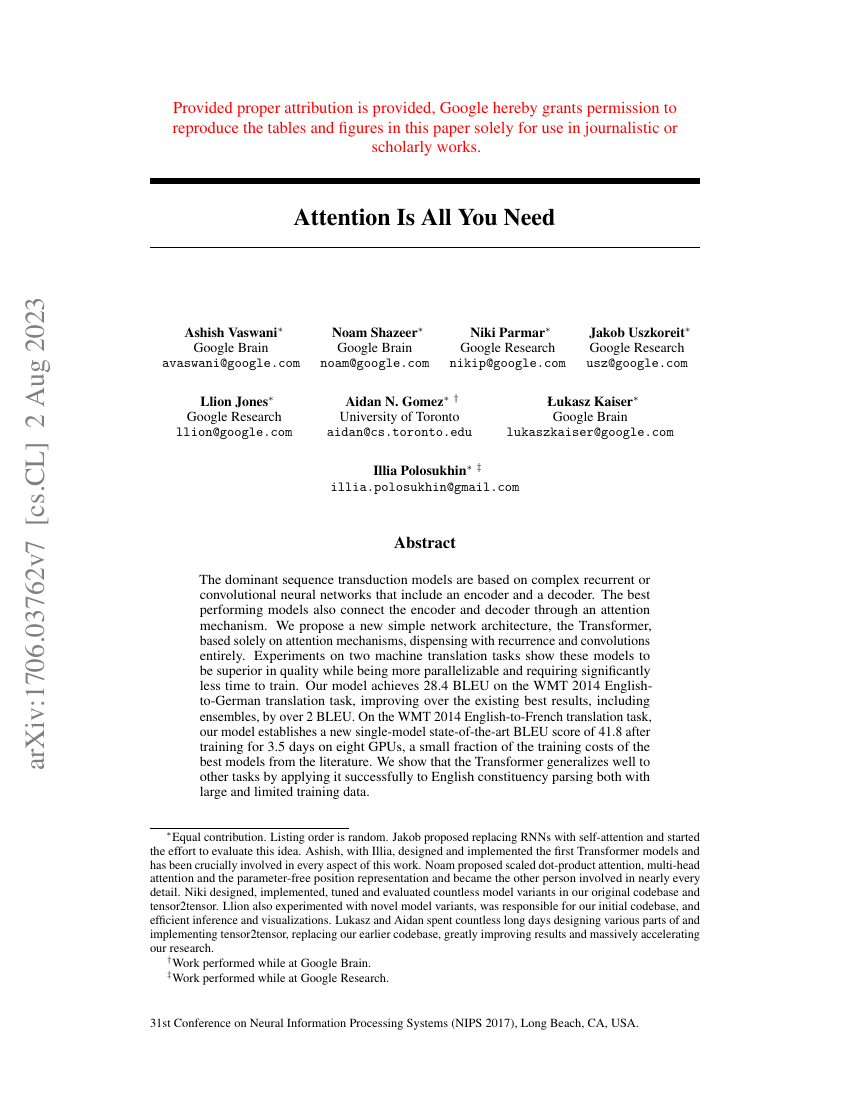

In [10]:
pdfs_as_PIL = convert_from_path('/Users/Alex/Desktop/paper_analysis_toolkit/attention.pdf', dpi=100)
pdfs_as_PIL[0]

In [15]:
def image_to_text(image):
    pixel_values = processor(image, return_tensors="pt").pixel_values

    outputs = model.generate(
        pixel_values.to(device),
        min_length=1,
        max_new_tokens=1200,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
    )

    sequence = processor.batch_decode(outputs, skip_special_tokens=True)[0]
    sequence = processor.post_process_generation(sequence, fix_markdown=False)

    return sequence

results = []
for image in tqdm(pdfs_as_PIL):
    results.append(image_to_text(image))

print(results)

 53%|█████▎    | 8/15 [10:08<08:52, 76.01s/it]


KeyboardInterrupt: 

## Generate transcription

Next, we let the model autoregressively generate the text appearning in the PDF. This is a lot faster on GPU than on CPU.

The authors did define some custom `StoppingCriteria`(which determine when the model should stop generating), so we're going to use them here as well.

In [5]:
# prepare image for the model
pixel_values = processor(images=image, return_tensors="pt").pixel_values
print(pixel_values.shape)

torch.Size([1, 3, 896, 672])


In [6]:
from transformers import StoppingCriteria, StoppingCriteriaList
from collections import defaultdict

class RunningVarTorch:
    def __init__(self, L=15, norm=False):
        self.values = None
        self.L = L
        self.norm = norm

    def push(self, x: torch.Tensor):
        assert x.dim() == 1
        if self.values is None:
            self.values = x[:, None]
        elif self.values.shape[1] < self.L:
            self.values = torch.cat((self.values, x[:, None]), 1)
        else:
            self.values = torch.cat((self.values[:, 1:], x[:, None]), 1)

    def variance(self):
        if self.values is None:
            return
        if self.norm:
            return torch.var(self.values, 1) / self.values.shape[1]
        else:
            return torch.var(self.values, 1)


class StoppingCriteriaScores(StoppingCriteria):
    def __init__(self, threshold: float = 0.015, window_size: int = 200):
        super().__init__()
        self.threshold = threshold
        self.vars = RunningVarTorch(norm=True)
        self.varvars = RunningVarTorch(L=window_size)
        self.stop_inds = defaultdict(int)
        self.stopped = defaultdict(bool)
        self.size = 0
        self.window_size = window_size

    @torch.no_grad()
    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor):
        last_scores = scores[-1]
        self.vars.push(last_scores.max(1)[0].float().cpu())
        self.varvars.push(self.vars.variance())
        self.size += 1
        if self.size < self.window_size:
            return False

        varvar = self.varvars.variance()
        for b in range(len(last_scores)):
            if varvar[b] < self.threshold:
                if self.stop_inds[b] > 0 and not self.stopped[b]:
                    self.stopped[b] = self.stop_inds[b] >= self.size
                else:
                    self.stop_inds[b] = int(
                        min(max(self.size, 1) * 1.15 + 150 + self.window_size, 4095)
                    )
            else:
                self.stop_inds[b] = 0
                self.stopped[b] = False
        return all(self.stopped.values()) and len(self.stopped) > 0

In [7]:
# autoregressively generate tokens, with custom stopping criteria (as defined by the Nougat authors)
outputs = model.generate(pixel_values.to(device),
                          min_length=1,
                          max_length=3584,
                          bad_words_ids=[[processor.tokenizer.unk_token_id]],
                          return_dict_in_generate=True,
                          output_scores=True,
                          stopping_criteria=StoppingCriteriaList([StoppingCriteriaScores()]),
)

/var/folders/4r/jrg941lx3055l4wvdxp9zpvh0000gp/T/ipykernel_29888/4023200142.py:23: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1760.)
  return torch.var(self.values, 1) / self.values.shape[1]


KeyboardInterrupt: 

## Postprocess

Finally we decode the generated IDs back to text and postprocess the generation.

In [ ]:
generated = processor.batch_decode(outputs[0], skip_special_tokens=True)[0]
generated = processor.post_process_generation(generated, fix_markdown=False)
print(generated)



# Nougat: Neural Optical Understanding for Academic Documents

 Lukas Blecher

Correspondence to: lblecher@meta.com

Guillem Cucurull

Thomas Scialom

Robert Stojnic

Meta AI

The paper reports 8.1M papers but the authors recently updated the numbers on the GitHub page https://github.com/allenai/s2orc

###### Abstract

Scientific knowledge is predominantly stored in books and scientific journals, often in the form of PDFs. However, the PDF format leads to a loss of semantic information, particularly for mathematical expressions. We propose Nougat (**N**eural **O**ptical **U**nderstanding for **A**cademic Documents), a Visual Transformer model that performs an _Optical Character Recognition_ (OCR) task for processing scientific documents into a markup language, and demonstrate the effectiveness of our model on a new dataset of scientific documents. The proposed approach offers a promising solution to enhance the accessibility of scientific knowledge in the digital age, by bridging the